# Logging Feature Plots

`Rubicon_ml` makes it easy to log plots with features and artifacts. In this example we'll walk through creating a feature dependency plot using the `shap` package and saving it to an artifact.

## Set up
First lets create a Rubicon `project` and create a pipeline with `rubicon_ml.sklearn.pipeline`.

In [1]:
import shap
import sklearn
from sklearn.datasets import load_wine
from rubicon_ml import Rubicon

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from rubicon_ml.sklearn import make_pipeline

rubicon = Rubicon(persistence="memory")
project = rubicon.get_or_create_project("Logging Feature Plots")

X, y = load_wine(return_X_y=True)

reg =  GradientBoostingRegressor(random_state=1)
pipeline=make_pipeline(project, reg)

pipeline.fit(X, y)

RubiconPipeline(project=<rubicon_ml.client.project.Project object at 0x1bc1f3880>,
                steps=[('gradientboostingregressor',
                        GradientBoostingRegressor(random_state=1))])

## Generating Data
After fitting the pipeline, using `shap.Explainer` we can generate `shap` values to later plot. For more information on generating `shap` values with `shap.explainer` check the documentation [here](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html).

In [2]:
explainer = shap.Explainer(pipeline[0])
shap_values = explainer.shap_values(X)

## Plotting
The generated `shap_values` can be passed to a `shap.depence_plot` to generate a dependence plot. `pl.gcf()` allows the plot generated by `shap` to be saved to a variable. Using `matplotlib.pyplot` and  `io`, shap plots can be saved to a `byte` representation. Here a feature and its plot are both logged with`rubicon_ml.Features` and `rubuicon_ml.Artifact` respectively. These `features` and `artifacts` are logged to the same `rubicon_ml.Experiment` which are being kept track of with an experiment tag.  

In [3]:
import matplotlib.pyplot as pl
import io

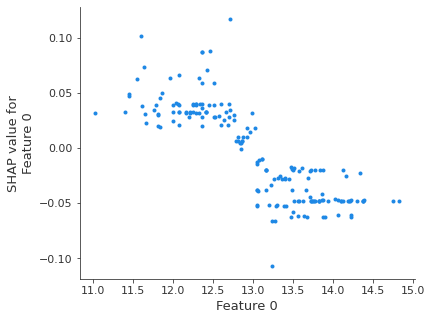

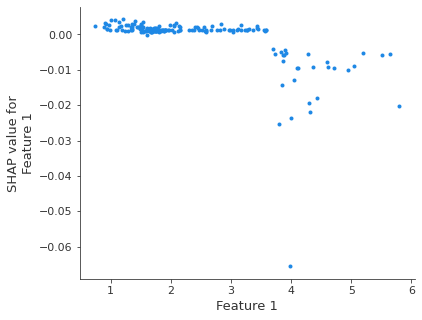

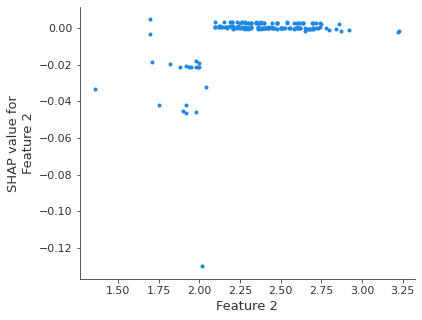

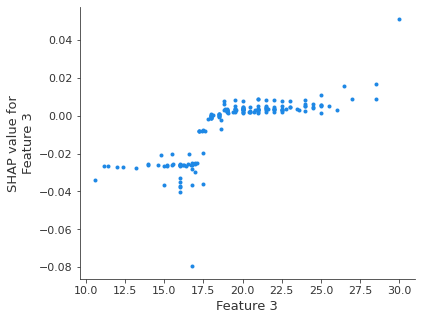

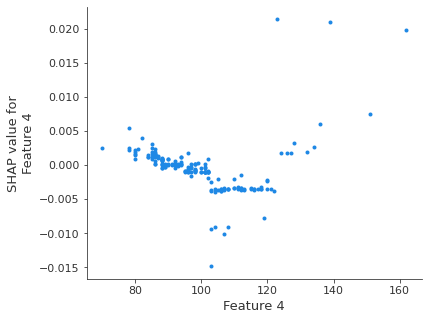

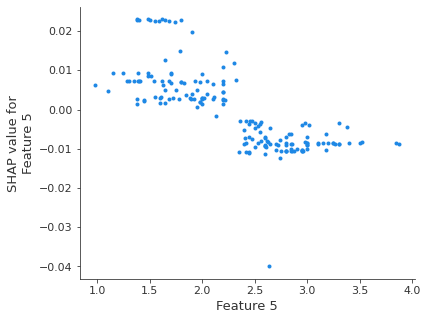

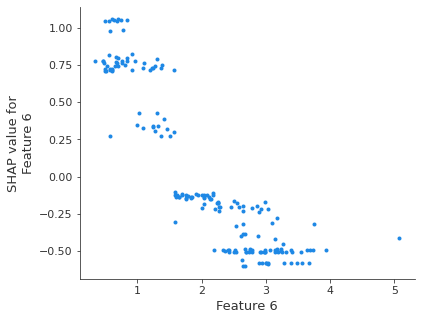

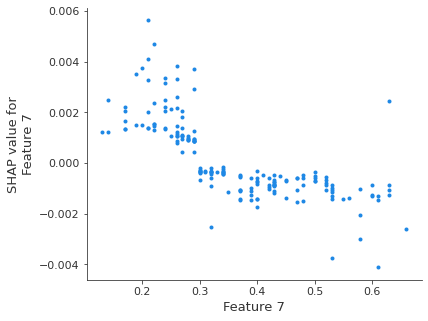

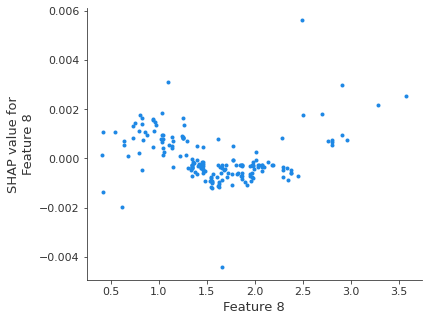

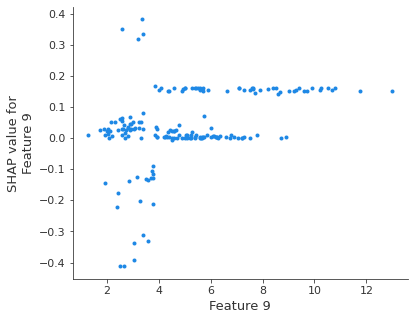

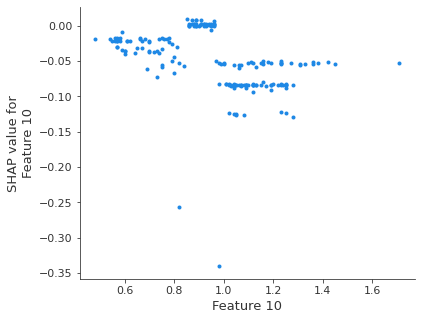

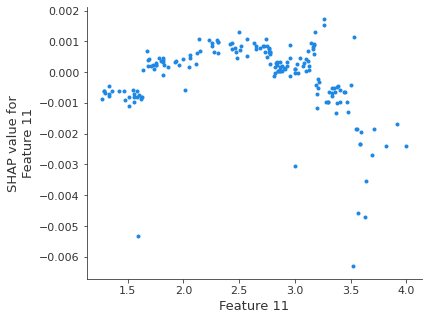

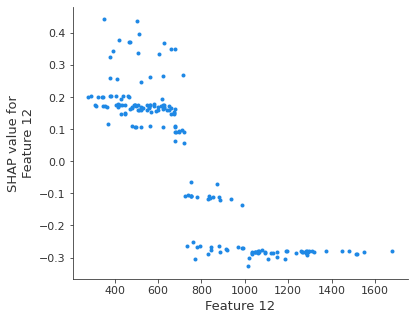

In [4]:
for x in range(reg.n_features_in_):
    feature_name="feature "+str(x)
    exp=project.log_experiment()
    exp.log_feature(feature_name)
    shap.dependence_plot(x, shap_values, X, interaction_index=None, show=False)
    fig = pl.gcf()
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    exp.log_artifact(data_bytes=buf.read(),name=feature_name+" dependency plot")
    exp.add_tags([feature_name])
    buf.close()


## Retrieving your logged plot and features programmatically

Finally, using the tag for each experiment, we can retrieve a feature and its associated plot. For this example we'll inspect `feature 6`. With `IO` and `PIL`, after retrieving the PNG byte representation of the plot, the plot can be rendered as a PNG image. 

In [5]:
import io
from PIL import Image

exp=project.experiments(tags=["feature 6"])[0]
feature=exp.feature("feature 6")
artifact_plot=exp.artifact("feature 6 dependency plot")
imageScatterPlotStream = io.BytesIO(artifact_plot.data)
scatter_plot_image = Image.open(imageScatterPlotStream)

Finally, view the dependence plot for `feature 6` using `display`. 

feature 6 SHAP dependence plot


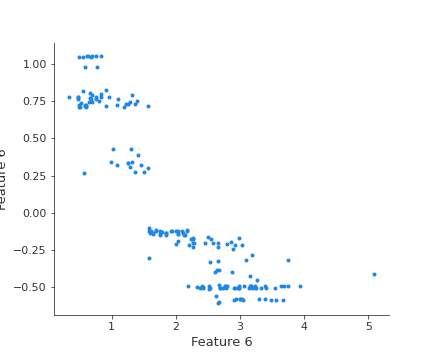

In [6]:
print(feature.name +" SHAP dependence plot")
display(scatter_plot_image)